# 멀티 암드 밴딧 알고리즘

A/B Test 를 넘어 명시적인 최적화와 좀 더 빠른 의사결정을 가능하게 한다.

주로 it, 웹 같이 실험의 변환이 더 자유로운 환경에서 많이 씁니다. 


# 실험 조건 

1. 우리는 마케팅 켐페인을 진행하고 있음.

2. 마케팅에서 2가지 광고 옵션(A,B)를 선택할 수 있음.

3. 목표는 가장 높은 광고 클릭수를 달성하는 것.

4. 하지만 우리는 두 광고가 어떤 클릭률을 가질지 사전 정보를 알 수 없음.

어떤식으로 최적화된 광고 선택을 할 수 있을까?

CTR: 클릭률. 100번 보여지고 10번 클릭되면 CTR = 10 /100 = 0.1

Regret: 후회값 
가능한 가장 높은 CTR과 실제 선택된 CTR의 차이. 예를들어 A의 CTR이 0.1 B의 CTR이 0.3일때 우리가 매번 A를 선택한다면 Reget은 0.3 - 0.1 = 0.2 가 된다. 




우리는 가장 적은 Regret(후회값)을 달성한다면 가장 최적화된 광고 선택을 했다고 할 수 있을 것입니다.

멀티 암드 밴딧을 위한 4가지 방법이 있습니다. 


1. Random Selection

2. Epsiolon Greedy

3. Thompson Sampling

4. Upper Confidence Bound(UCB1)

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import beta, bernoulli
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import random
import math

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

In [29]:
def algorithm_performance():
    """
    이 듀토리얼에서 사용될 알고리즘의 성능을 보여주는 함수입니다. 
    Function that will show the performance of each algorithm we will be using in this tutorial.
    """
    
    ## 각각 광고가 몇번 선택되었는지 계산합니다. calculate how many time each Ad has been choosen
    count_series = pd.Series(index_list).value_counts(normalize=True)
    print('Ad #0 는', count_series[0]*100, '% 선택됨')
    print('Ad #1 는', count_series[1]*100, '% 선택됨')
    
    print('전체 리워드 (전체 클릭 횟수):', total_reward) ## 전체 리워드 프린트 
    
    x = np.arange (0, n, 1)

    ## Ad #0의 계산된 CTR 그리기 
    data1 = go.Scatter(x=x,
                       y=ctr[0],
                       name='Calculated CTR #0',
                       line=dict(color=('rgba(10, 108, 94, .7)'),
                                 width=2))

    ##  Ad #0의 참 CTR 그리기 
    data2 = go.Scatter(x=[0, n],
                       y=[ACTUAL_CTR[0]] * 2,
                       name='Actual CTR #0 value',
                       line = dict(color = ('rgb(205, 12, 24)'),
                                   width = 1,
                                   dash = 'dash'))

    ##  Ad #1의 계산된 CTR 그리기 
    data3 = go.Scatter(x=x,
                       y=ctr[1],
                       name='Calculated CTR #1',
                       line=dict(color=('rgba(187, 121, 24, .7)'),
                                 width=2))

    ##  Ad #1의 참 CTR 그리기 
    data4 = go.Scatter(x=[0, n],
                       y=[ACTUAL_CTR[1]] * 2,
                       name='Actual CTR #1 value',
                       line = dict(color = ('rgb(205, 12, 24)'),
                                   width = 1,
                                   dash = 'dash'))

    ## 후회값을 시행횟수의 함수로 그려보기
    data5 = go.Scatter(x=x,
                       y=regret_list,
                       name='Regret')

    layout = go.Layout(title='Simulated CTR Values and Algorithm Regret',
                       xaxis={'title': 'Trial Number'},
                       yaxis1={'title': 'CTR value'},
                       yaxis2={'title': 'Regret Value'}
                       )
    fig = tools.make_subplots(rows=2, cols=1, print_grid=False, shared_yaxes=True, shared_xaxes=True)

    fig.append_trace(data1, 1, 1)
    fig.append_trace(data2, 1, 1)
    fig.append_trace(data3, 1, 1)
    fig.append_trace(data4, 1, 1)
    fig.append_trace(data5, 2, 1)

    fig['layout'].update(layout)
    iplot(fig, show_link=False)

In [3]:
ACTUAL_CTR = [.45, .65]
print('Ad #0 의 실제 클릭률:', ACTUAL_CTR[0])
print('Ad #1 의 실제 클릭률:', ACTUAL_CTR[1])

Actual CTR for Ad #0 is: 0.45
Actual CTR for Ad #1 is: 0.65


# 1. Random Selection

0% - 탐험(Exploration)
100% - 탐사(Exploitation)          

가장 나이브한 방법으로 시작합니다. 그저 랜덤하게 보여질 광고를 선택합니다.               
그러므로 RS는 어떠한 탐사가 없고, 단순히 랜덤하게 선택합니다.

In [ ]:
## 각 알고리즘에서 우리는 1000번의 시행(trial)을 합니다. 
n = 1000

In [5]:
regret = 0 
total_reward = 0
regret_list = [] ## 각 impression(광고 노출, tial)에서의 후회값을 저장하기 위한 리스트 
ctr = {0: [], 1: []} ## 계산된 CTR을 위한 리스트들 
index_list = [] ## 랜덤하게 선택된 광고의 숫자를 저장하기 위한 리스트

## 최초값은 둘 다 0으로 설정
impressions = [0,0] # ad 0일때의 광고노출, ad 1일때의 광고 노출 
clicks = [0,0] # ad 0 일때의 클릭수, ad 1일때의 클릭 수 

for i in range(n):    
    
    random_index = np.random.randint(0,2,1)[0] ## [0,1] 사이에서 랜덤한 정수를 선택함. 이때 선택된 정수가 0이면 ad 0, 1이면 ad1 선택됨
    index_list.append(random_index) ## radom_index를 리스트에 저장 
    
    impressions[random_index] += 1 ## 선택된 광고의 impressions에 1을 추가  
    did_click = bernoulli.rvs(ACTUAL_CTR[random_index]) ## 실제 CTR의 확률로 사람이 클릭할지(1), 클릭하지 않을지 (0)을 베르누이 분포로 시뮬레이션
    
    if did_click:
        clicks[random_index] += did_click ## 클릭했다면, 주어진 광고의 clicks에 더해주기(클릭이 안됐으면 did_click의 값이 0이므로 변동 없음)
    
    ## 계산된 CTR을 구하고, 리스트에 저장하기
    if impressions[0] == 0:
        ctr_0 = 0
    else:
        ctr_0 = clicks[0]/impressions[0]
        
    if impressions[1] == 0:
        ctr_1 = 0
    else:
        ctr_1 = clicks[1]/impressions[1]
        
    ctr[0].append(ctr_0)
    ctr[1].append(ctr_1)
    
    ## 후회값과 리워드 저장하기 
    regret += max(ACTUAL_CTR) - ACTUAL_CTR[random_index]
    regret_list.append(regret)
    total_reward += did_click

In [6]:
algorithm_performance()

Ad #0 has been shown 49.2 % of the time.
Ad #1 has been shown 50.8 % of the time.
Total Reward (Number of Clicks): 570


/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



우리가 랜덤하게 뽑기 때문에 후횟값도 지속적으로 상승하는것을 확인할 수 있음.

> Question:
> 왜 랜덤하게 뽑았을때 후횟값이 지속적으로 상승하는 것일까요?
> 힌트: 후횟값의 정의를 생각해주세요 
>
> A: (답을 해주세요)

RS는 두가지 경우에 사용합니다.

1. 계산된 CTR에 대해서 더 자신있고 싶을때,(계산된 CTR이 가장 참 CTR에 가까워질 수 있음)

2. 우리가 무한한 시간과 예산을 가지고 있을 때. 

In [7]:
## 다른 알고리즘과 비교를 위해 리워드와 후횟값을 저장합니다. 
random_dict = {'reward':total_reward, 
               'regret_list':regret_list, 
               'ads_count':pd.Series(index_list).value_counts(normalize=True)}


# 2. Epsilon Greedy

* ~ 15% 탐험
* ~ 85% 활용
                         
                                   
                                   
1. 처음 최초의 실험을 진행합니다.(탐험)

2. 최초 실험기간 가장 높은 Score를 가진 변량(우승 변량)을 선택합니다.

3. Epsilon value를 설정합니다.

4. (1-e)% 만큼 우승 변량을 선택하고, 나머지 e%만큼 다른 옵션에서 랜덤하게 선택합니다.(활용)

※: 우리 경우에는 두 가지 선택밖에 없기 때문에 e%만큼에서도 랜덤이 아니라 확정적으로 선택합니다. 

In [33]:
e = .05 ## Epsilon 값을 설정합니다. 
n_init = 100 ## 이긴 광고를 선택할때 시도할 횟수 
impressions = [0,0]
clicks = [0,0]

for i in range(n_init):
    random_index = np.random.randint(0,2,1)[0] # [0,1]에서 랜덤한 정수 선택 
    
    impressions[random_index] += 1
    did_click = bernoulli.rvs(ACTUAL_CTR[random_index])
    if did_click:
        clicks[random_index] += did_click
        
ctr_0 = clicks[0] / impressions[0]
ctr_1 = clicks[1] / impressions[1]
win_index = np.argmax([ctr_0, ctr_1]) ## 더 높은 CTR을 가진 광고를 선택함. 

print('최초의  #', n_init, '번 시행 후에 ', win_index, '가 가장 높은 CTR =', round(np.max([ctr_0, ctr_1]), 2), 
      '(참 CTR은 ', ACTUAL_CTR[win_index], ').'
      '\n 선택된 광고가', (1-e)*100, '% 만큼 선택될 것입니다.')

최초의  # 100 번 시행 후에  1 가 가장 높은 CTR = 0.64 (참 CTR은  0.65 ).
 선택된 광고가 95.0 % 만큼 선택될 것입니다.


In [34]:
regret = 0 
total_reward = 0
regret_list = [] 
ctr = {0: [], 1: []}
index_list = [] 
impressions = [0,0] 
clicks = [0,0]

for i in range(n):    
    
    epsilon_index = random.choices([win_index, 1-win_index], [1-e, e])[0] # 최초 시도에서 이긴 광고는 1-e 확률, 진 광고는 e 확률로 선택됨 
    index_list.append(epsilon_index) # 선택된 광고를 list에 저장 
    
    impressions[epsilon_index] += 1
    did_click = bernoulli.rvs(ACTUAL_CTR[epsilon_index]) # 실제 CTR 확률만큼 클릭되면 1, 클릭되지 않으면 0
    if did_click:
        clicks[epsilon_index] += did_click
    
    if impressions[0] == 0:
        ctr_0 = 0
    else:
        ctr_0 = clicks[0]/impressions[0]
        
    if impressions[1] == 0:
        ctr_1 = 0
    else:
        ctr_1 = clicks[1]/impressions[1]
        
    ctr[0].append(ctr_0)
    ctr[1].append(ctr_1)
    
    regret += max(ACTUAL_CTR) - ACTUAL_CTR[epsilon_index]
    regret_list.append(regret)
    total_reward += did_click

In [35]:
algorithm_performance()

Ad #0 has been shown 5.7 % of the time.
Ad #1 has been shown 94.3 % of the time.
Total Reward (Number of Clicks): 618


/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



훨씬 낫죠! 후횟값의 자리수가 얼마나 떨어졌는지 확인해봅시다. RS에 비해서 훨씬 훌륭합니다. 그러나 문제가 있을 수 있습니다.

> Question 과연 최초 실험에서 이긴 값이 항상 최적의 변량이라는 보장이 있을까요?
>
> A: 답을 달아 주세요.

만약 최적이 아닌 차선의(suboptimal) 변량이 선택된다면 후회값을 증가시키고, reward를 감소시킬것입니다. 큰수의 법칙에 따라 최초의 실험 횟수가 더 많을 수록, 우리는 더 올바른 최적의 변량을 선택할 가능성이 클 것입니다. 하지만 마케팅에서는 요행에 의지하는 것은 우리가 원하는 바가 아니며, 우리는 우리의 최초 실험횟수가  큰수에 도달했기를 바랄 수 밖에 없습니다. 

> Question 원준은 최초의 실험횟수가 충분한지 확신이 없었습니다. 그래서 최초의 실험횟수만을 반복하다 보니 전체 실험 횟수를 초과했습니다. 이 경우 결과적으로 원준은 어떤 방법을 사용한 것이 될까요?
>
> A: 답을 달아 주세요.

이긴 변량을 선택할 확률인 e를 설정하는 것 역시 좋은 점입니다. 

In [12]:
epsilon_dict = {'reward':total_reward, 
                'regret_list':regret_list, 
                'ads_count':pd.Series(index_list).value_counts(normalize=True)}

# 3. 톰슨 샘플링 

50% 탐색 

50% 활용

e-Greedy 알고리즘에서 더 정교한 탐색을 사용하는 기법입니다.
여기서는 베타 분포를 활용할 것이지만 다른 어떠한 분포에서의 샘플로 일반화 될 수 있습니다.

> 베타분포는 [0,1] 사이에서 정의되는 연속형 확률분포로, 2가지 양의 모수, alpha, betha 로 표현할 수 있습니다. 주로 베이지안 통계 추정에서 활용을 합니다. 

* 로직
  1. 사전 분포의 패러미터로 alpha, betha를 선택한다.
  2. 다음 공식으로 alpha와 betha의 값을 다시 계산한다. 
    a = prior + hits,
    b = prior + misses 
    (여기선 hits 는 클릭 횟수, misses는 클릭으로 연결되지않은 광고 노출수)
    Prior는 참 CTR에 대해 우리가 가진 사전 정보이다. 우리는 아직 알 수 없기 때문에 1.0을 쓴다.                   
  3. 베타 분포의 각 변량 B(ai,bi)에서 샘플링함으로서 참 CTR을 추정한다. 글고 가장 높은 값의 샘플을 고른다(estimated CTR).                
  4. 2-3을 반복한다. 

> 베타 분포 참고 자료                       
 >  http://varianceexplained.org/statistics/beta_distribution_and_baseball/



In [36]:
regret = 0 
total_reward = 0
regret_list = [] 
ctr = {0: [], 1: []}
index_list = [] 
impressions = [0,0] 
clicks = [0,0]
priors = (1, 1)
win_index = np.random.randint(0,2,1)[0] ## 최초로 선택될 광고를 랜덤하게 선택함. 

for i in range(n):    
    
    impressions[win_index] += 1
    did_click = bernoulli.rvs(ACTUAL_CTR[win_index])
    if did_click:
        clicks[win_index] += did_click
    
    ctr_0 = random.betavariate(priors[0]+clicks[0], priors[1] + impressions[0] - clicks[0]) # Betha(성공횟수 (a-1) , 실패횟수(b-1))로 [0,1]의 값을 반환함.
    ctr_1 = random.betavariate(priors[0]+clicks[1], priors[1] + impressions[1] - clicks[1])
    win_index = np.argmax([ctr_0, ctr_1])
    index_list.append(win_index)
    
    ctr[0].append(ctr_0)
    ctr[1].append(ctr_1)
    
    regret += max(ACTUAL_CTR) - ACTUAL_CTR[win_index]
    regret_list.append(regret)    
    total_reward += did_click

In [14]:
## 베타 분포 그려보기 
x = np.arange (0, 1, 0.01)
y = beta.pdf(x, priors[0]+clicks[0], priors[1] + impressions[0] - clicks[0])
y /= y.max() ## normalize 하기 

data1 = go.Scatter(x=x,
                   y=y,
                   name='Beta Distribution (Ad #0)',
                   marker = dict(color=('rgba(10, 108, 94, 1)')),
                   fill='tozeroy',
                   fillcolor = 'rgba(10, 108, 94, .7)')

data2 = go.Scatter(x = [ACTUAL_CTR[0]] * 2,
                   y = [0, 1],
                   name = 'Actual CTR #0 Value',
                   mode='lines',
                   line = dict(
                       color = ('rgb(205, 12, 24)'),
                       width = 2,
                       dash = 'dash'))

y = beta.pdf(x, priors[0]+clicks[1], priors[1] + impressions[1] - clicks[1])
y /= y.max()

data3 = go.Scatter(x=x,
                   y=y,
                   name='Beta Distribution (Ad #1)',
                   marker = dict(color=('rgba(187, 121, 24, 1)')),
                   fill='tozeroy',
                   fillcolor = 'rgba(187, 121, 24, .7)')

data4 = go.Scatter(x = [ACTUAL_CTR[1]] * 2,
                   y = [0, 1],
                   name = 'Actual CTR #1 Value',
                   mode='lines',
                   line = dict(
                       color = ('rgb(205, 12, 24)'),
                       width = 2,
                       dash = 'dash'))

layout = go.Layout(title='Beta Distributions for both Ads',
                   xaxis={'title': 'Possible CTR values'},
                   yaxis={'title': 'Probability Density'})

fig = go.Figure(data=[data1, data2, data3, data4], layout=layout)

# fig = tools.make_subplots(rows=1, cols=2, print_grid=False, shared_xaxes=False,
#                           subplot_titles=('Beta Distribution (Ad #0)','Beta Distribution (Ad #1)'))

# fig.append_trace(data1, 1, 1)
# fig.append_trace(data2, 1, 1)
# fig.append_trace(data3, 1, 2)
# fig.append_trace(data4, 1, 2)

# fig['layout'].update(showlegend=False)

iplot(fig, show_link=False)

실제 광고 #0의 참 CTR은 100% 확률로 0.45
실제 광고 #1의 참 CTR은 100% 확률로 0.65

그것을 우리가 추정한 CTR의 값들은 몇퍼센트일지 베타 분포를 통해 추정할 수 있습니다. 

In [15]:
algorithm_performance()


Ad #0 has been shown 5.2 % of the time.
Ad #1 has been shown 94.8 % of the time.
Total Reward (Number of Clicks): 632


/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



후횟값이 지금까지 중 가장 낮습니다. 후횟값의 상승은 매번 광고 #0 이 선택할때마다 발생했습니다. CTR 값 플랏에서 최초에 초록색이 황동색보다 더 커서 광고 0이 나타날때가 있습니다. 

In [16]:
thompson_dict = {'reward':total_reward, 
                 'regret_list':regret_list, 
                 'ads_count':pd.Series(index_list).value_counts(normalize=True)}

# 4. Upper Confidence Bound(UCB1) 

* 50% 탐사 
* 50% 활용 

톰슨 샘플링에서 달라진 점은, 각 변량에 대해서 불확실성을 더 고려함.
한 변량에 대해서 더욱 불확실성할수록, 거기에 대해 더 중요하게 탐사함.

알고리즘은 가장 높은 신뢰 구간 값(UCB)를 가진 변량을 선택하는데,
다음과 같이 정의할 수 있음.

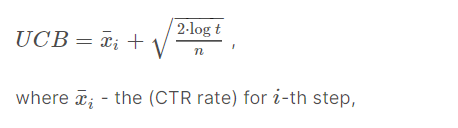

t는 지금까지의 총 시행, n은 선택된 변량의 시행을 나타냅니다.

즉 계산된 CTR에 시행횟수에 비해 적게 골라진 광고를 선택하게 함

로직은 다소 간단함

1. 모든 변량에 대해서 UCB 계산.

2. 가장 높은 UCB를 가지는 변량을 선택함.

3. 다시 1로 돌아감. 

> Question:  
>
> root 식에 들어가있는 logtn과 n은 각각 어떤 의미를 상징할까요?
> 이러한 보정치는 톰슨 샘플링과 어떤식으로 달라지게 만들까요?
> 
> A: 답을 달아봅시다. 

In [17]:
regret = 0 
total_reward = 0
regret_list = [] 
index_list = [] 
impressions = [0,0] 
clicks = [0,0]
ctr = {0: [], 1: []}
total_reward = 0

for i in range(n):
    
    index = 0
    max_upper_bound = 0
    for k in [0,1]:
        if (impressions[k] > 0):
            CTR = clicks[k] / impressions[k] # 지금까지 계산된 CTR 
            delta = math.sqrt(2 * math.log(i+1) / impressions[k]) # i+1 : 총 시행횟수, 식에서는 t, impressions[k] : 광고 k가 노출된 수 
                                                                  # 총 시행횟수(분자) 광고 k가 선택된 수(분모)이므로 k가 적게 설치될수록 delta가 커짐. 
            upper_bound = CTR + delta                             # CTR + delta라는 보정치가 더해지는 형태 
            ctr[k].append(CTR)
        else:
            upper_bound = 1e400 # 무한대, 아주 큰 수, else 문에만 있기 때문에 impressions[k] = 0 일때만 선택됨 
        if upper_bound > max_upper_bound: # k가 0일때, 1일때 비교하면서 index를 k로 설정하게 하는 역할 
            max_upper_bound = upper_bound
            index = k
    index_list.append(index)
    impressions[index] += 1
    reward = bernoulli.rvs(ACTUAL_CTR[index])
    
    clicks[index] += reward
    total_reward += reward
    
    regret += max(ACTUAL_CTR) - ACTUAL_CTR[index]
    regret_list.append(regret)

In [18]:
algorithm_performance()

Ad #0 has been shown 14.799999999999999 % of the time.
Ad #1 has been shown 85.2 % of the time.
Total Reward (Number of Clicks): 614


/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



불확실성의 해소를 위해 광고 # 0이 선택될때마다 후회값이 커지는 것을 볼 수 있다.

최적의 변량을 더 자주 고르고 싶지만 또한 불확실성을 줄이는 데도 관심이 있으면 UCB가 좋습니다.

In [19]:
ucb1_dict = {'reward':total_reward, 
             'regret_list':regret_list, 
             'ads_count':pd.Series(index_list).value_counts(normalize=True)}

# 비교


랜덤 선택을 제외하고는 
실제 광고 #1 이 참 CTR이 높기 때문에 더 많이 뽑혔음을 확인할 수 있다. 

In [20]:
data1 = go.Bar(x=['Random Selection', 'Epsilon Greedy', 'Thompson Sampling', 'UCB1'],
               y=[random_dict['ads_count'][0], 
                  epsilon_dict['ads_count'][0], 
                  thompson_dict['ads_count'][0],
                  ucb1_dict['ads_count'][0]],
               name='Ad #0',
               marker=dict(color='rgba(10, 108, 94, .7)'))

data2 = go.Bar(x=['Random Selection', 'Epsilon Greedy', 'Thompson Sampling', 'UCB1'],
               y=[random_dict['ads_count'][1], 
                  epsilon_dict['ads_count'][1], 
                  thompson_dict['ads_count'][1],
                  ucb1_dict['ads_count'][1]],
               name='Ad #1',
               marker=dict(color='rgba(187, 121, 24, .7)'))

data = [data1, data2]
layout = go.Layout(title='Ratio of appearance of both Ads throughout the trials',
                   xaxis={'title': 'Algorithm'},
                   yaxis={'title': 'Ratio'},
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

> Question : 
> 왜 UCB1은 e-Greedy나 톰슨 샘플링보다 광고 0의 선택비율이 높을까요?
>
> A: (답을 달아 봅시다)

In [21]:
data1 = go.Scatter(
    x=np.arange (0, n, 1),
    y=random_dict['regret_list'],
    name='Random Selection',
    marker=dict(color='#ffcc66')
)
data2 = go.Scatter(
    x=np.arange (0, n, 1),
    y=epsilon_dict['regret_list'],
    name='e-Greedy',
    marker=dict(color='#0099ff')
)
data3 = go.Scatter(
    x=np.arange (0, n, 1),
    y=thompson_dict['regret_list'],
    name='Thompson Sampling',
    marker=dict(color='#ff3300')
)
data4 = go.Scatter(
    x=np.arange (0, n, 1),
    y=ucb1_dict['regret_list'],
    name='UCB1',
    marker=dict(color='#33cc33')
)

layout = go.Layout(
    title='Regret by the Algorithm',
    xaxis={'title': 'Trial'},
    yaxis={'title': 'Regret'}
)

data = [data1, data2, data3, data4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

톰슨 샘플링과 e-Greedy는 대부분 광고 1을 선택했기 때문에 가장 낮은 후회값을 가지게 된다. 

In [22]:
data = go.Bar(
    x=[ucb1_dict['reward'], thompson_dict['reward'], epsilon_dict['reward'], random_dict['reward']],
    y=['UCB1', 'Thompson Sampling', 'e-Greedy','Random Selection'],
    orientation = 'h',
    marker=dict(color=['#33cc33', '#ff3300', '#0099ff', '#ffcc66']),
    opacity=0.7
)

text = go.Scatter(
    x=[ucb1_dict['reward'], thompson_dict['reward'], epsilon_dict['reward'], random_dict['reward']],
    y=['UCB1', 'Thompson Sampling', 'e-Greedy', 'Random Selection'],
    mode='text',
    text=[ucb1_dict['reward'], thompson_dict['reward'], epsilon_dict['reward'], random_dict['reward']],
    textposition='middle left',
    line = dict(
        color = ('rgba(255,141,41,0.6)'),
        width = 1
    ),
    textfont=dict(
        family='sans serif',
        size=16,
        color='#000000'
    )
)

data = [data,text]

layout = go.Layout(
    title='Total Reward by Algorithms',
    xaxis={'title': 'Total Reward (Clicks)'},
    margin={'l':200},
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

가장 낮은 후회값을 가졌더라도 가장 높은 리워드를 보장하지는 않습니다. 

> Question:  
> 
> 왜 가장 낮은 후횟값을 가지더라도 높은 리워드를 보장하지 않을까요? 
>
> A: (답을 달아 봅시다.)

톰슨 샘플링이 일반적으로 가장 좋은 선택이지만, 우리는 다른 알고리즘도 살펴보고 어떻게 언제 그들이 효과적일지 논의해봐야합니다. 

> Question:  
> 
> 오늘 배운 알고리즘들은 지도학습일까요? 비지도학습일까요? 아니면 다른 학습 방법일까요?  
>
> A: (답을 달아 봅시다.)


실습 토론: 다른 케이스에서는 어떻게 될까요? 
각자 코드를 짜보거나 토론해보도록 합시다.

1. 광고 #0과 광고 #1의 CTR 차이가 미약하다면?

2. E-Greedy에서 최초 실험의 숫자가 작다면?

3. 각 알고리즘마다 시행하는 횟수를 줄인다면?

4. 현재 예시에서는 광고의 종류가 2가지 밖에 없었습니다. 만약 광고의 선택지가 훨씬 더 다양하다면 어떻게 될까요? 
